In [1]:
import os
import pandas as pd
import corneto as cn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

directory = 'results'

df_list = []

for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        df_list.append(df)

combined_df = pd.concat(df_list, ignore_index=True)

In [2]:
max_edges = None
for d_path in combined_df.dataset.unique():
    n_samples = combined_df[combined_df.dataset==d_path].num_samples.unique()[0]
    for i in range(n_samples):
        G = cn.Graph.load(os.path.join(d_path, f"graph_sample_{i}.pkl.xz"))
        if max_edges is None:
            max_edges = G.shape[1]
        else:
            if G.shape[1] > max_edges:
                max_edges = G.shape[1]
max_edges

2991

In [3]:
combined_df["avg_error"] = 1 - combined_df["mean_prop_score"]
combined_df["normalized_edges"] = combined_df["total_edges_across_samples"]/max_edges
combined_df

,dataset,num_samples,num_nodes,num_terminals,num_common_nodes,mode,lambda,max_time,mean_prop_score,total_edges_across_samples,avg_error,normalized_edges
0,datasets/d2,10,1000,20,5,multi,0.40,3600,1.000000,183,0.000000,0.061184
1,datasets/d3,10,1000,50,10,multi,0.50,3600,1.000000,375,0.000000,0.125376
2,datasets/d3,10,1000,50,10,single,0.30,3600,1.000000,484,0.000000,0.161819
3,datasets/d2,10,1000,20,5,multi,0.45,3600,1.000000,183,0.000000,0.061184
4,datasets/d2,10,1000,20,5,multi,2.00,3600,0.986401,175,0.013599,0.058509
...,...,...,...,...,...,...,...,...,...,...,...,...
108,datasets/d2,10,1000,20,5,multi,1.00,3600,0.995678,178,0.004322,0.059512
109,datasets/d2,10,1000,20,5,single,1.50,3600,0.860340,180,0.139660,0.060181
110,datasets/d2,10,1000,20,5,multi,4.00,3600,0.859222,122,0.140778,0.040789
111,datasets/d2,10,1000,20,5,single,3.00,3600,0.265963,52,0.734037,0.017385


In [4]:
#Wimport seaborn as sns
#sns.scatterplot(data=combined_df, x="avg_error", y="normalized_edges", hue="mode")

In [5]:
def compute_pareto_front(df, x_col, y_col):
    # Extract the x and y values from the DataFrame
    x = df[x_col].values
    y = df[y_col].values

    # Sort the values by x
    sorted_indices = np.argsort(x)
    sorted_x = x[sorted_indices]
    sorted_y = y[sorted_indices]

    # Initialize the Pareto front
    pareto_x = [sorted_x[0]]
    pareto_y = [sorted_y[0]]

    # Loop to find the Pareto front
    for i in range(1, len(sorted_x)):
        if sorted_y[i] <= pareto_y[-1]:  # assuming lower y is better
            pareto_x.append(sorted_x[i])
            pareto_y.append(sorted_y[i])

    return pareto_x, pareto_y

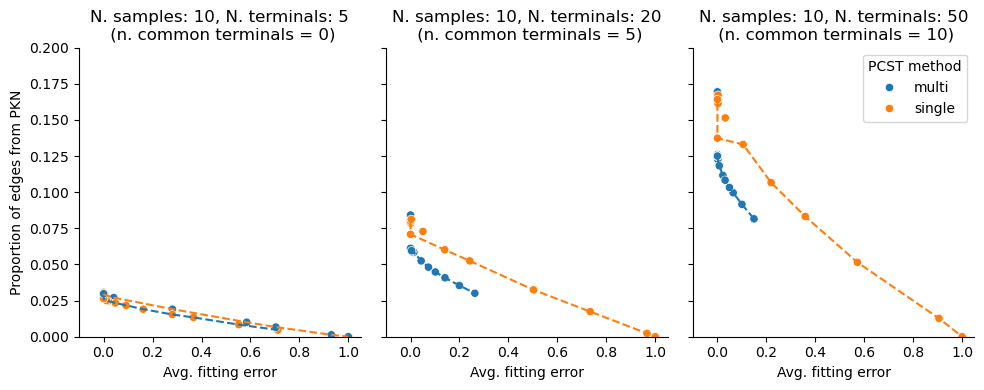

In [6]:
def plot_dataset(dataset, data=combined_df, x_label="avg_error", y_label="normalized_edges", **kwargs): 
    df_data = data[data.dataset==dataset]
    ax = sns.scatterplot(data=df_data, x=x_label, y=y_label, hue="mode", **kwargs)
    ax.set_xlim(-0.1, None)
    ax.set_ylim(0, 0.2)
    sns.despine()

    # Multi
    df_multi = df_data[df_data["mode"] == "multi"]
    pareto_x, pareto_y = compute_pareto_front(df_multi, x_label, y_label)
    ax.plot(pareto_x, pareto_y, linestyle="--")
    
    # Single
    df_single = df_data[df_data["mode"] == "single"]
    pareto_x, pareto_y = compute_pareto_front(df_single, x_label, y_label)
    ax.plot(pareto_x, pareto_y, linestyle="--")
    ax.set_xlabel("Avg. fitting error")
    ax.set_ylabel("Proportion of edges from PKN")

    
    #n_samples, n_diff_inputs, n_diff_outputs, mean_shared_inputs, mean_shared_outputs = summary_dataset(dataset)
    ax.set_title(f"N. samples: {df_data.num_samples.unique()[0]}, N. terminals: {df_data.num_terminals.unique()[0]}\n (n. common terminals = {df_data.num_common_nodes.unique()[0]})")

    if "legend" in kwargs and kwargs["legend"]:
        ax.legend(title="PCST method")
        
    return ax

fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharey=True, sharex=True)
plot_dataset("datasets/d1", ax=ax[0], legend=False)
plot_dataset("datasets/d2", ax=ax[1], legend=False)
plot_dataset("datasets/d3", ax=ax[2], legend=True)
plt.tight_layout()
plt.savefig("pcst_single_multi.pdf", format="pdf")

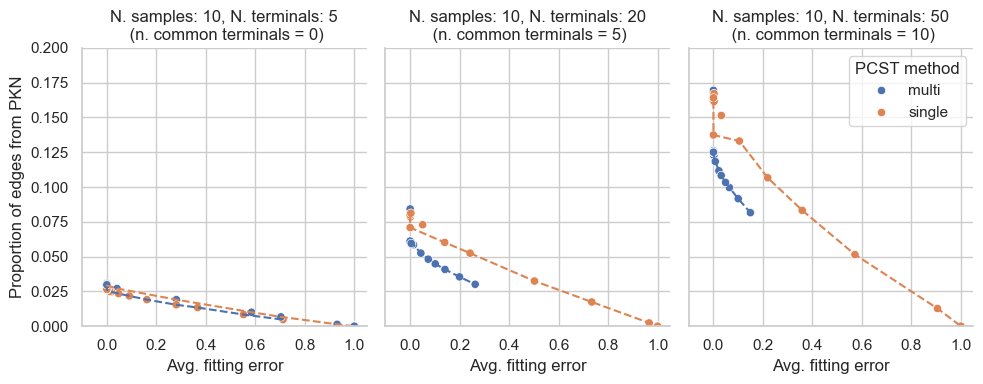

In [7]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharey=True, sharex=True)
plot_dataset("datasets/d1", ax=ax[0], legend=False)
plot_dataset("datasets/d2", ax=ax[1], legend=False)
plot_dataset("datasets/d3", ax=ax[2], legend=True)
plt.tight_layout()
plt.savefig("pcst_single_multi_wg.pdf", format="pdf")
